In [1]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Print TF version, keep the version in mind when you look the documentation.
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow 2.x selected.
TensorFlow version: 2.1.0


In [2]:
import numpy as np
import os
import pandas as pd
import time, gc
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import pyarrow.parquet as pq
from PIL import Image
from PIL import ImageEnhance
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
path = "/content/drive/My Drive/Data/bengaliai-cv19/" # TCC
# path="/content/drive/My Drive/data 2040 midterm private folder/Data/bengaliai-cv19/" # LSY

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Obtain Data from CSV and Parquet

***The codes in model building and training are credit to [this pubic notebook](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn)***

Train, test label from CSV


In [0]:
train_df_ = pd.read_csv(path + 'train.csv')
test_df_ = pd.read_csv(path + 'test.csv')
class_map_df = pd.read_csv(path + 'class_map.csv')
sample_sub_df = pd.read_csv(path + 'sample_submission.csv')

In [0]:
train_df_0 = pd.merge(pd.read_parquet(path + f'train_image_data_{0}.parquet'), train_df_, on='image_id')

## Train Mode

To increase training speed and model accuracy, the images are first cropped to fufill the image with characters and then resized to a 64 by 64 pixel image.

In [0]:
# resize the dataframe
from tqdm.auto import tqdm
def resize(df, size=128, need_progress_bar=True, sharpness=0.0):
    resized = {}
    resize_size=size
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            # Add sharpness
            # image = Image.fromarray(image)
            # image = ImageEnhance.Sharpness(image)
            # image = image.enhance(sharpness)
            # image = np.array(image)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
            del image
    else:
        for i in range(df.shape[0]):
            image=df.loc[df.index[i]].values.reshape(137,236)
            # Add sharpness
            # image = Image.fromarray(image)
            # image = ImageEnhance.Sharpness(image)
            # image = image.enhance(sharpness)
            # image = np.array(image)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
            del image
    resized = pd.DataFrame(resized).T
    return resized

In [18]:
resized_train_df_0 = resize(train_df_0.drop(['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'], axis=1))

In [19]:
resized_train_df_0.head

<bound method NDFrame.head of        0      1      2      3      4      ...  16379  16380  16381  16382  16383
0        251    252    251    252    252  ...    255    255    255    254    254
1        255    255    255    255    255  ...    255    255    255    255    255
2        253    253    254    254    254  ...    140    178    186    226    230
3        249    251    253    251    250  ...    253    254    254    254    254
4        255    255    255    255    255  ...    255    255    255    255    255
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
50205    254    254    254    254    254  ...    254    254    254    254    254
50206    254    254    254    254    254  ...    255    255    255    255    255
50207    244    242    240    240    238  ...    241    245    247    247    247
50208    245    240    237    237    241  ...    161    160    163    175    198
50209    254    211    170    148    181  ...    255    255    255    255    25

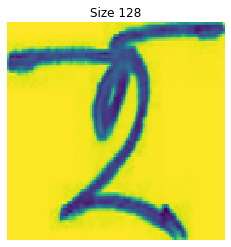

In [20]:
# sample 0
plt.imshow(np.array(resized_train_df_0.iloc[1]).reshape(128, 128))
plt.axis('off')
plt.title('Size 128')
plt.savefig('Size128.png')

In [0]:
# Build DataGenerator
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## Model Training

In [0]:
IMG_SIZE=96
N_CHANNELS=1
batch_size = 256
epochs = 30
HEIGHT = 137
WIDTH = 236

In [0]:
# Build an in itial model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
inputs = keras.Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
root_dense = model.layers[-3].name
vowel_dense = model.layers[-2].name
consonant_dense = model.layers[-1].name
print(root_dense, vowel_dense, consonant_dense)

dense_2 dense_3 dense_4


Build a Tensorboard for visualizing the training/validation accuracy history and training/validation loss.

In [0]:
# Tensor Board
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [0]:
# Learning rate schedule
learning_rate_reduction_root = tf.keras.callbacks.ReduceLROnPlateau(monitor=root_dense+'_loss', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = tf.keras.callbacks.ReduceLROnPlateau(monitor=vowel_dense+'_loss', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = tf.keras.callbacks.ReduceLROnPlateau(monitor=consonant_dense+'_loss', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

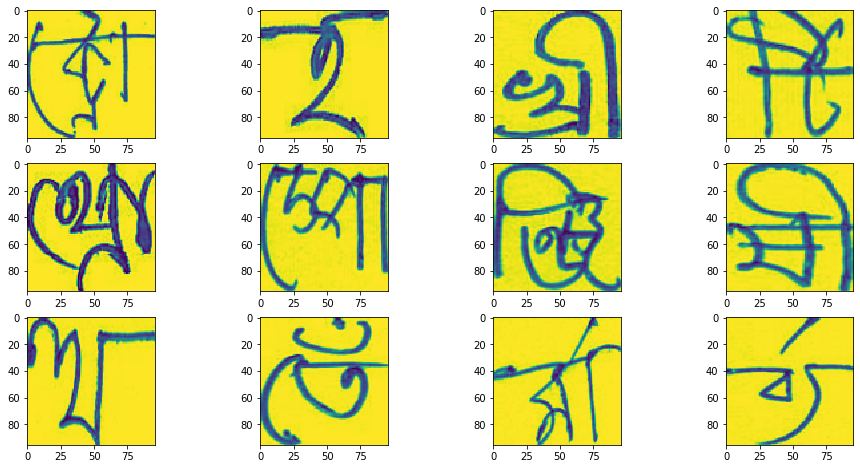


Training images: (50210, 96, 96, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 62s 344ms/step - loss: 7.8650 - dense_2_loss: 4.7686 - dense_3_loss: 1.8922 - dense_4_loss: 1.2042 - dense_2_accuracy: 0.0299 - dense_3_accuracy: 0.3459 - dense_4_accuracy: 0.6219 - val_loss: 6.5963 - val_dense_2_loss: 4.5170 - val_dense_3_loss: 1.0979 - val_dense_4_loss: 0.9835 - val_dense_2_accuracy: 0.0373 - val_dense_3_accuracy: 0.6164 - val_dense_4_accuracy: 0.6497
Epoch 2/30
180/180 [==============================] - 52s 287ms/step - loss: 6.5897 - dense_2_loss: 4.3708 - dense_3_loss: 1.2301 - dense_4_loss: 0.9888 - dense_2_accuracy: 0.0515 - dense_3_accuracy: 0.5688 - dense_4_accuracy: 0.6552 - val_loss: 5.6146 - val_dense_2_loss: 4.0322 - val_dense

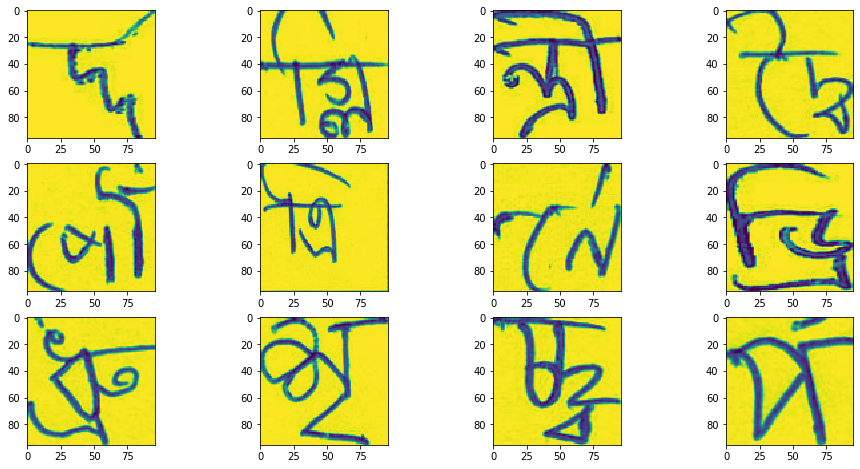


Training images: (50210, 96, 96, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 51s 285ms/step - loss: 0.9599 - dense_2_loss: 0.5509 - dense_3_loss: 0.2383 - dense_4_loss: 0.1708 - dense_2_accuracy: 0.8526 - dense_3_accuracy: 0.9321 - dense_4_accuracy: 0.9471 - val_loss: 0.4698 - val_dense_2_loss: 0.2887 - val_dense_3_loss: 0.0940 - val_dense_4_loss: 0.0856 - val_dense_2_accuracy: 0.9188 - val_dense_3_accuracy: 0.9759 - val_dense_4_accuracy: 0.9761
Epoch 2/30
180/180 [==============================] - 51s 284ms/step - loss: 0.8257 - dense_2_loss: 0.4591 - dense_3_loss: 0.2184 - dense_4_loss: 0.1483 - dense_2_accuracy: 0.8725 - dense_3_accuracy: 0.9372 - dense_4_accuracy: 0.9546 - val_loss: 0.4259 - val_dense_2_loss: 0.2669 - val_dense

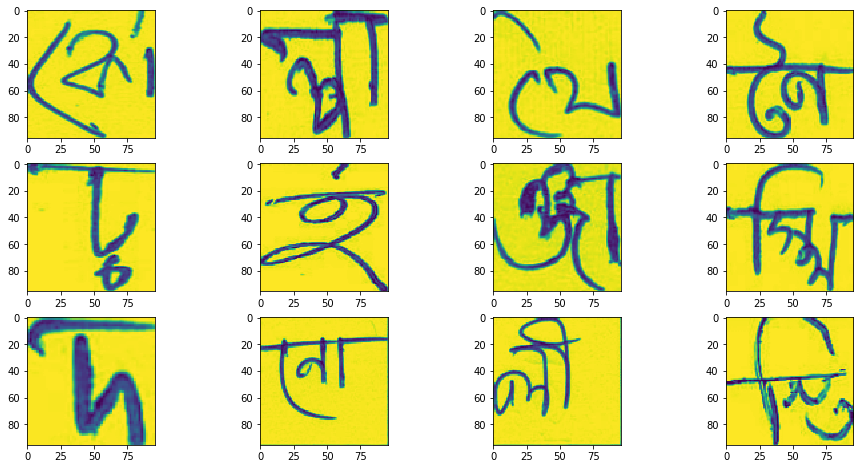


Training images: (50210, 96, 96, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 51s 285ms/step - loss: 0.7385 - dense_2_loss: 0.4177 - dense_3_loss: 0.1887 - dense_4_loss: 0.1321 - dense_2_accuracy: 0.8887 - dense_3_accuracy: 0.9459 - dense_4_accuracy: 0.9613 - val_loss: 0.3968 - val_dense_2_loss: 0.2425 - val_dense_3_loss: 0.0860 - val_dense_4_loss: 0.0695 - val_dense_2_accuracy: 0.9360 - val_dense_3_accuracy: 0.9771 - val_dense_4_accuracy: 0.9793
Epoch 2/30
180/180 [==============================] - 51s 284ms/step - loss: 0.6151 - dense_2_loss: 0.3361 - dense_3_loss: 0.1674 - dense_4_loss: 0.1115 - dense_2_accuracy: 0.9058 - dense_3_accuracy: 0.9518 - dense_4_accuracy: 0.9653 - val_loss: 0.3941 - val_dense_2_loss: 0.2382 - val_dense

In [0]:
for i in range(4):
    train_df = pd.merge(pd.read_parquet(path+f'train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id', 'grapheme'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit(datagen.flow(x_train, 
                            {root_dense: y_train_root, vowel_dense: y_train_vowel, consonant_dense: y_train_consonant}, batch_size=batch_size),
                            epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                            steps_per_epoch=x_train.shape[0] // batch_size, 
                            callbacks=[learning_rate_reduction_root, 
                                        learning_rate_reduction_vowel, 
                                        learning_rate_reduction_consonant, 
                                        tensorboard_cb])

    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [0]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 162), started 1:18:24 ago. (Use '!kill 162' to kill it.)

In [0]:
%tensorboard --logdir=./my_logs --port=6006

In [0]:
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant

In [0]:
# Save model
model_name = 'vanilla_96_PosSharpen_model.h5'
save_dir = os.path.join('/content/drive/My Drive/Data/bengaliai-cv19', 'saved_modelssss')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/initial_model.h5 


In [0]:
# Test Data
dict_pred = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet(path + f'test_image_data_{i}.parquet') 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(dict_pred):
        dict_pred[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(dict_pred[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
